#### 네이버 영화 리뷰 데이터에 대한 감정분석

#### 라이브러리 설치 및 환경 세팅

In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 13.4MB/s 
     |████████████████████████████████| 890kB 48.2MB/s 
     |████████████████████████████████| 2.9MB 49.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1bebf20830379cb3abd7f61cfa02e93cb9da998942fc4ccb49156a93140e4b22
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 41.7MB/s 
     |████████████████████████████████| 460kB 51.4MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import datetime
from google.colab import files

#### 데이터 로드

In [4]:
# 네이버 영화리뷰 데이터 다운
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [5]:
# 데이터 df에 저장
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

#train.head()

(150000, 3)
(50000, 3)


In [6]:
# 리뷰 문장 확인
review_text = train['document']
review_text[:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

#### 모델 학습을 위한 전처리

In [7]:
# 리뷰 문장에 대해 KoNLPy를 활용하여 단어 토큰화 진행
okt = Okt()

dm = pd.DataFrame(columns=['document'])

for i in review_text[:5]:
  a = okt.morphs(str(i), stem = True)
  a = ' '.join(a)
  dm = dm.append({'document': a}, ignore_index=True)

In [12]:
# 토큰화 결과 확인
print(review_text[8])
print(okt.morphs(str(review_text[8]), stem = True))

액션이 없는데도 재미 있는 몇안되는 영화
['액션', '이', '없다', '재미', '있다', '몇', '안되다', '영화']


In [ ]:
review_text = dm['document']
review_text[:5]

0                                  아 더빙 .. 진짜 짜증나다 목소리
1            흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍다 않다
2                              너 무재 밓었 다그 래서 보다 추천 한 다
3                  교도소 이야기 구먼 .. 솔직하다 재미 는 없다 .. 평점 조정
4    사이 몬페 그 의 익살스럽다 연기 가 돋보이다 영화 ! 스파이더맨 에서 늙다 보이다...
Name: document, dtype: object

In [ ]:
# KoNLPy 형태소 분석을 활용하여 토큰화 진행

okt = Okt()

cnt=0
b = []
for i in review_text:
  #print(cnt)
  a = okt.morphs(str(i), stem = True)
  #a.insert(0, "[CLS]")
  #a.append("[SEP]")
  b.append(a)
  #cnt+=1

In [ ]:
#with open('movie_text.txt', 'w') as f:
    #for i in b:
        #f.write("%s\n" % i)

#files.download('movie_text.txt')

In [ ]:
# BERT 형식으로 변환
review_text = ["[CLS] " + str(text) + " [SEP]" for text in review_text]
review_text[:5]

['[CLS] 아 더빙 .. 진짜 짜증나다 목소리 [SEP]',
 '[CLS] 흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍다 않다 [SEP]',
 '[CLS] 너 무재 밓었 다그 래서 보다 추천 한 다 [SEP]',
 '[CLS] 교도소 이야기 구먼 .. 솔직하다 재미 는 없다 .. 평점 조정 [SEP]',
 '[CLS] 사이 몬페 그 의 익살스럽다 연기 가 돋보이다 영화 ! 스파이더맨 에서 늙다 보이다 하다 커스틴 던스트 가 너무나도 이쁘다 보이다 [SEP]']

In [ ]:
# 레이블 추출
labels = train['label'].values
labels

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
# 토큰화: 토큰화는 1차적으로 KoNLPy를 이용하여 진행하였고, bert 형식에 맞게 2차 토큰화 진행
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(text) for text in review_text]

print (review_text[0])
print (tokenized_texts[0])

[CLS] 아 더빙 .. 진짜 짜증나다 목소리 [SEP]
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나다', '목', '##소', '##리', '[SEP]']


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


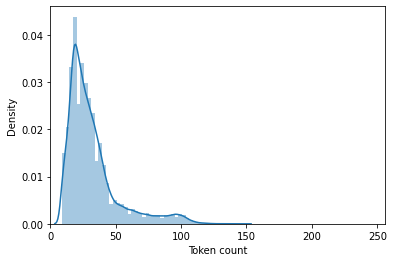

In [ ]:
# 입력 토큰의 최대 길이 설정을 위한 확인
token_lens = []
for txt in sentences:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# 입력 토큰의 최대 시퀀스 길이 설정
MAX_LEN = 150

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  89782,   9284,  22333,  12692,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
#print(' Original: ', sentences[0])
#print('Tokenized: ', tokenizer.tokenize(sentences[0]))
#print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

In [ ]:
print(' Original: ', review_text[0])
print('Tokenized: ', tokenized_texts[0])
print('Token IDs: ', input_ids[0])

 Original:  [CLS] 아 더빙 .. 진짜 짜증나다 목소리 [SEP]
Tokenized:  ['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나다', '목', '##소', '##리', '[SEP]']
Token IDs:  [   101   9519   9074 119005    119    119   9708 119235   9715 119230
  89782   9284  22333  12692    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0     

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=22, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=22, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101, 106154,    100,  80564,   9251,  11261,   9143,  11903,   9568,
         63243, 106154,  53354,   9654, 118940,   9836,  73352,  80564,   9089,
          8985,  12692,  11903,   8996,  43911,   9612,  10407,  14279,   9087,
         16985, 118676,  11903,    102,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#### test set

In [ ]:
# 리뷰 문장 추출
review_text = test['document']
review_text[:5]

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
Name: document, dtype: object

In [ ]:
len(review_text)

50000

In [ ]:
dm2 = pd.DataFrame(columns=['document'])

for i in review_text:
  a = okt.morphs(str(i), stem = True)
  a = ' '.join(a)
  dm2 = dm2.append({'document': a}, ignore_index=True)

In [ ]:
dm2

,document
0,굳다 ㅋ
1,GDNTOPCLASSINTHECLUB
2,뭐 야 이 평점 들 은 .... 나쁘다 않다 10 점 짜다 리 는 더 더욱 아니다
3,지루하다 않다 완전 막장 임 ... 돈 주다 보기 에는 ....
4,3 D 만 아니다 별 다섯 개 주다 .. 왜 3 D 로 나오다 제 심기 를 불편하다...
...,...
49995,오랜 만 에 평점 로 기다 하다 ㅋㅋ 킹왕짱 쌈뽕 한 영화 를 만나다 강렬하다 육 쾌함
49996,의지 박약 들 이나 하다 탈영 은 일단 주인공 김대희 닮다 이등병 찌다 따다 OOOO
49997,그림 도 좋다 완성 도도 높다 ... 보다 내내 불안하다 만들다
49998,절대 보다 서다 안 되다 영화 .. 재미 도 없다 기분 만 잡 치고 .. 하다 세트...


In [ ]:
review_text = dm2['document']
review_text

0                                                     굳다 ㅋ
1                                     GDNTOPCLASSINTHECLUB
2            뭐 야 이 평점 들 은 .... 나쁘다 않다 10 점 짜다 리 는 더 더욱 아니다
3                      지루하다 않다 완전 막장 임 ... 돈 주다 보기 에는 ....
4        3 D 만 아니다 별 다섯 개 주다 .. 왜 3 D 로 나오다 제 심기 를 불편하다...
                               ...                        
49995     오랜 만 에 평점 로 기다 하다 ㅋㅋ 킹왕짱 쌈뽕 한 영화 를 만나다 강렬하다 육 쾌함
49996      의지 박약 들 이나 하다 탈영 은 일단 주인공 김대희 닮다 이등병 찌다 따다 OOOO
49997                  그림 도 좋다 완성 도도 높다 ... 보다 내내 불안하다 만들다
49998    절대 보다 서다 안 되다 영화 .. 재미 도 없다 기분 만 잡 치고 .. 하다 세트...
49999                                         마무리 는 또 왜 이래
Name: document, Length: 50000, dtype: object

In [ ]:
# KoNLPy 형태소 분석을 활용하여 토큰화 진행

okt = Okt()

cnt=0
b = []
for i in review_text:
  #print(cnt)
  a = okt.morphs(str(i), stem = True)
  a.insert(0, "[CLS]")
  a.append("[SEP]")
  b.append(a)
  #cnt+=1

In [ ]:
# BERT의 입력 형식에 맞게 변환
review_text = ["[CLS] " + str(text) + " [SEP]" for text in review_text]
#review_text[:10]

# 라벨 추출
labels = test['label'].values
#labels

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(text) for text in review_text]

#print (sentences[0])
#print (tokenized_texts[0])

# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 150

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])


# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tensor([  101,   101,  8911, 11903,   100,   102,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
#### 모델 생성

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 2

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 시드 고정
seed_val = 22
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 학습 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:06:39.
  Batch 1,000  of  4,219.    Elapsed: 0:13:30.
  Batch 1,500  of  4,219.    Elapsed: 0:20:21.
  Batch 2,000  of  4,219.    Elapsed: 0:27:13.
  Batch 2,500  of  4,219.    Elapsed: 0:34:04.
  Batch 3,000  of  4,219.    Elapsed: 0:40:56.
  Batch 3,500  of  4,219.    Elapsed: 0:47:47.
  Batch 4,000  of  4,219.    Elapsed: 0:54:39.

  Average training loss: 0.38
  Training epcoh took: 0:57:39

Running Validation...
  Accuracy: 0.86
  Validation took: 0:02:13

======== Epoch 2 / 2 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:06:51.
  Batch 1,000  of  4,219.    Elapsed: 0:13:43.
  Batch 1,500  of  4,219.    Elapsed: 0:20:34.
  Batch 2,000  of  4,219.    Elapsed: 0:27:26.
  Batch 2,500  of  4,219.    Elapsed: 0:34:18.
  Batch 3,000  of  4,219.    Elapsed: 0:41:10.
  Batch 3,500  of  4,219.    Elapsed: 0:48:02.
  Batch 4,000  of  4,219.    Elapsed: 0:54:54.

  Average training loss: 0.28
  

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# 모델 weight save
torch.save(model.state_dict(), 'checkpoint_2.pth')

# download checkpoint file
files.download('checkpoint_2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 모델 weight load
path = F"/content/drive/MyDrive/Colab Notebooks/NLP/기말_감정분석/checkpoint.pth"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#### Prediction

In [ ]:
## 캐글 데이터
from google.colab import files
myfile = files.upload()

#test_kg = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

Saving ko_data.csv to ko_data.csv


In [ ]:
import io
#pd.read_csv로 csv파일 불러오기
test_kg = pd.read_csv(io.BytesIO(myfile['ko_data.csv']), encoding='CP949')
test_kg.head()

,Id,Sentence
0,0,정말 많이 울었던 영화입니다.
1,1,시간 낭비예요.
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.


In [ ]:
review_text = test_kg.Sentence

In [ ]:
review_text

0                                         정말 많이 울었던 영화입니다.
1                                                 시간 낭비예요.
2                   포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3                     지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4                                이걸 영화로 만드는 거야?얼마나 가는지 보자.
                               ...                        
11182    이 영화를 커플에게 추천합니다. 영화관에 가다보면 평생 잊지 못할 추억이 하나 생길...
11183                                       심심__ 그냥 한효주 cf
11184    공감해서 눈물나는 영화. 안 보신분들이 전부 제가 울었다고 하면 의아해하실텐데 보면...
11185                                        오토바이 신은 최고네요.
11186                                     개병헌 쓰면 엉망이 된다ㅋㅋㅋ
Name: Sentence, Length: 11187, dtype: object

In [ ]:
dm2 = pd.DataFrame(columns=['document'])

for i in review_text:
  a = okt.morphs(str(i), stem = True)
  a = ' '.join(a)
  dm2 = dm2.append({'document': a}, ignore_index=True)

In [ ]:
review_text = dm2['document']
review_text

0                                         정말 많이 울다 영화 이다 .
1                                               시간 낭비 예요 .
2             포스터 를 저렇게 밖에 만들다 못 하다 제작자 의 소심하다 침 을 뱉다 싶다 .
3                 지금 보다 재미있다 영화 !!! 코믹 과 감동 !!! 그리고 요리 !!!
4                             이 걸 영화로 만들다 거야 ? 얼마나 가다 보다 .
                               ...                        
11182    이 영화 를 커플 에게 추천 하다 . 영화관 에 가다 보다 평생 잊다 못 하다 추억...
11183                                      심심 __ 그냥 한효주 cf
11184    공감 하다 눈물나다 영화 . 안 보신 분들 이 전부 제 가 울다 하다 의아 하다 보...
11185                                     오토바이 신다 최고 네 요 .
11186                                  개 병헌 쓰다 엉망 이 되다 ㅋㅋㅋ
Name: document, Length: 11187, dtype: object

In [ ]:
#review_text = [str(sentence) for sentence in review_text]
#sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

In [ ]:
# 입력 데이터 변환
def convert_input_data(review_text):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(text) for text in review_text]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 150

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(review_text):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(review_text)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
#logits = test_sentences(review_text)

In [ ]:
#print(logits)
#print(np.argmax(logits))

In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

[[-0.5976036  0.6385989]]
1


In [ ]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))

[[ 2.6262083 -3.1040645]]
0


In [ ]:
result = []
#for i in range(10):
for i in review_text:
  #print(review_text[i])
  logits = test_sentences([i])
  result.append(np.argmax(logits))

In [ ]:
len(result)

11187

In [ ]:
result_df = pd.DataFrame(data=result, columns=['Predicted'])
result_df

,Predicted
0,1
1,0
2,0
3,1
4,0
...,...
11182,1
11183,0
11184,1
11185,1


In [ ]:
result_df.to_csv('sample.csv')
files.download('sample.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_review = tokenizer.batch_encode_plus(
    review_text,#.tolist(),
    max_length = 150,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for test set
test_seq = torch.tensor(encoded_review['input_ids'])
test_mask = torch.tensor(encoded_review['attention_mask'])
#test_y = torch.tensor(test_labels.tolist())

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  #preds = preds.detach().cpu().numpy()
preds

SequenceClassifierOutput([('logits', tensor([[-2.2017,  1.8321],
                                   [ 0.2802, -0.3147],
                                   [-0.1917,  0.0109]], device='cuda:0'))])

In [ ]:
review_text ='완전 최고!!'

encoded_review = tokenizer.batch_encode_plus(
    review_text,#.tolist(),
    max_length = 150,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

preds = model(test_seq.to(device), test_mask.to(device))
print(preds)
print(np.argmax(preds))

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2017,  1.8321],
        [ 0.2802, -0.3147],
        [-0.1917,  0.0109]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
0


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
preds = np.argmax(output, axis = 1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {preds}')

AttributeError: ignored

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
preds = np.argmax(output, axis = 1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {preds}')

In [ ]:
preds = np.argmax(preds, axis = -1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {preds}')

Review text: 짱이다
Sentiment  : 0


In [ ]:
#output = model(input_ids, attention_mask)
_, prediction = torch.max(preds, dim=1)

TypeError: ignored

In [ ]:
import mecab
    mecab = mecab.MeCab()
    morph = []
    sentence = "담수와 염수가 급작스럽게 섞일 경우 대부분의 수생생물이 폐사하는 원인은?"
    for st in sentence.split(" "):
        count = 0
        for token in mecab.morphs(st):
            tk = token
            if count > 0:
                tk = "##" + tk
                morph.append(tk)
            else:
                morph.append(tk)
                count += 1
                
     print(morph)

IndentationError: ignored